# Deep Dream

this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def image_open(img_path):
    response = requests.get(img_path)
    img_screen = Image.open(BytesIO(response.content))
    return img_screen


def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im


def preprocess_image(pil_im, resize_im=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [31]:
from torch.optim import SGD




class DeepDream():
    def __init__(self, model, selected_layer, selected_filter, image):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.created_image = image.convert('RGB')
        self.hook_layer()
    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            self.conv_output = grad_out[0, self.selected_filter]


        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):

        self.processed_image = preprocess_image(self.created_image, True)
        optimizer = SGD([self.processed_image], lr=12,  weight_decay=1e-4)
        images = list()
        for i in range(1, 251):
            optimizer.zero_grad()
            x = self.processed_image
            for index, layer in enumerate(self.model):
                x = layer(x)
                if index == self.selected_layer:
                    break
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            loss.backward()
            optimizer.step()
            self.created_image = recreate_image(self.processed_image)
            if i % 20 == 0:
                print(self.created_image.shape)
                im =save_image(self.created_image)
                images.append(im)
        return images

In [32]:
cnn_layer = 10
filter_pos = 255
dd = DeepDream(pret_mod.features, cnn_layer, filter_pos, img)
images = dd.dream()

<ipython-input-30-f6dc3237ba4c>:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)


Iteration: 1 Loss: 5.02
Iteration: 2 Loss: 0.52
Iteration: 3 Loss: -3.07
Iteration: 4 Loss: -6.65
Iteration: 5 Loss: -10.13
Iteration: 6 Loss: -14.13
Iteration: 7 Loss: -17.17
Iteration: 8 Loss: -20.76
Iteration: 9 Loss: -24.50
Iteration: 10 Loss: -28.71
Iteration: 11 Loss: -32.60
Iteration: 12 Loss: -36.95
Iteration: 13 Loss: -40.73
Iteration: 14 Loss: -44.79
Iteration: 15 Loss: -48.90
Iteration: 16 Loss: -53.31
Iteration: 17 Loss: -57.68
Iteration: 18 Loss: -61.94
Iteration: 19 Loss: -66.48
Iteration: 20 Loss: -70.83
(224, 224, 3)
Iteration: 21 Loss: -75.18
Iteration: 22 Loss: -79.73
Iteration: 23 Loss: -84.58
Iteration: 24 Loss: -88.97
Iteration: 25 Loss: -93.33
Iteration: 26 Loss: -97.91
Iteration: 27 Loss: -102.13
Iteration: 28 Loss: -106.80
Iteration: 29 Loss: -111.45
Iteration: 30 Loss: -115.74
Iteration: 31 Loss: -119.84
Iteration: 32 Loss: -124.69
Iteration: 33 Loss: -129.03
Iteration: 34 Loss: -133.66
Iteration: 35 Loss: -138.12
Iteration: 36 Loss: -142.98
Iteration: 37 Loss:

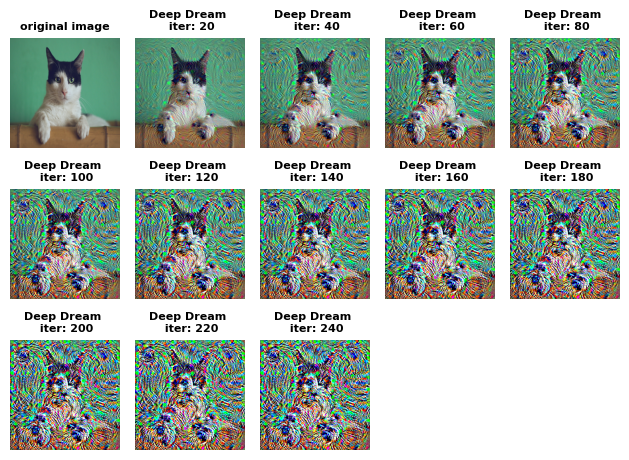

In [39]:
def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
      ax[-2].set_visible(False)
    plt.tight_layout()


imgs = [img]
imgs = imgs + images
captions = ['original image'] + ['Deep Dream \n iter: ' + str(i) for i in range(20,251,20)]
fig = download_images(imgs, captions, cols = 5, rows = 3, size = 8)

In [40]:
from torchvision import models
cnn_layer = 34
filter_pos = 94
img_path = "https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
image = image_open(img_path)
pret_mod =  models.vgg19(pretrained=True).features
dd = DeepDream(pret_mod, cnn_layer, filter_pos, image)
images = dd.dream()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.7MB/s]
<ipython-input-30-f6dc3237ba4c>:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_im = pil_im.resize((224, 224)

Iteration: 1 Loss: 4.21
Iteration: 2 Loss: 1.47
Iteration: 3 Loss: -4.16
Iteration: 4 Loss: -9.34
Iteration: 5 Loss: -14.02
Iteration: 6 Loss: -17.64
Iteration: 7 Loss: -23.13
Iteration: 8 Loss: -28.39
Iteration: 9 Loss: -35.39
Iteration: 10 Loss: -42.81
Iteration: 11 Loss: -48.54
Iteration: 12 Loss: -58.04
Iteration: 13 Loss: -59.84
Iteration: 14 Loss: -65.98
Iteration: 15 Loss: -76.58
Iteration: 16 Loss: -87.94
Iteration: 17 Loss: -96.29
Iteration: 18 Loss: -104.49
Iteration: 19 Loss: -113.25
Iteration: 20 Loss: -123.53
(224, 224, 3)
Iteration: 21 Loss: -135.11
Iteration: 22 Loss: -143.24
Iteration: 23 Loss: -148.46
Iteration: 24 Loss: -157.39
Iteration: 25 Loss: -168.09
Iteration: 26 Loss: -176.32
Iteration: 27 Loss: -183.47
Iteration: 28 Loss: -195.25
Iteration: 29 Loss: -203.84
Iteration: 30 Loss: -215.99
Iteration: 31 Loss: -221.49
Iteration: 32 Loss: -236.23
Iteration: 33 Loss: -244.33
Iteration: 34 Loss: -255.92
Iteration: 35 Loss: -260.47
Iteration: 36 Loss: -269.26
Iteration:

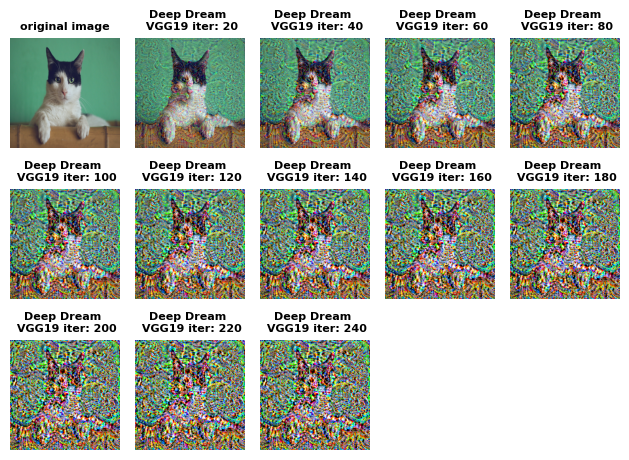

In [41]:
imgs = [img]
imgs = imgs + images
captions = ['original image'] + ['Deep Dream \n VGG19 iter: ' + str(i) for i in range(20,251,20)]
fig = download_images(imgs, captions, cols = 5, rows = 3, size = 8)